In [3]:
from orphics import sehgal
import numpy as np
import os
import matplotlib.pyplot as plt
from pixell import enmap, curvedsky, utils, enplot
import healpy as hp
from cosmikyu import config, datasets
from cosmikyu import utils as cutils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
SDS_model = datasets.SehgalDataSet(sehgal_dir, data_type="modelv3", transforms=[], dummy_label=False)
data = np.zeros((5, 128, 128*len(SDS_model)))
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]

for i in range(len(SDS_model)):
    sidx = 128*i
    data[...,sidx: sidx+128] = SDS_model[i]

kappa


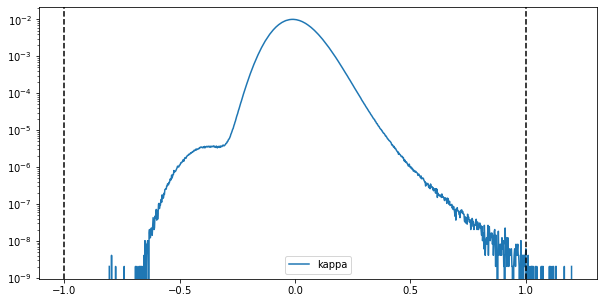

[-0.8058947688755432, 0.08057424893809918, -2.6322709341968308e-05, 0.08057424893809918]


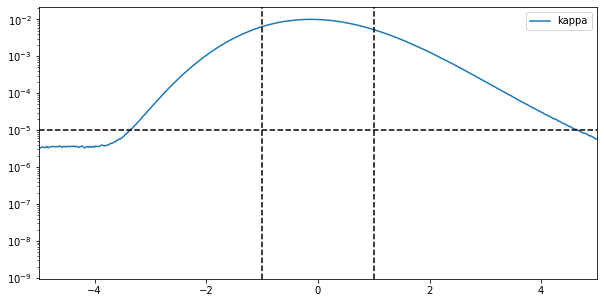

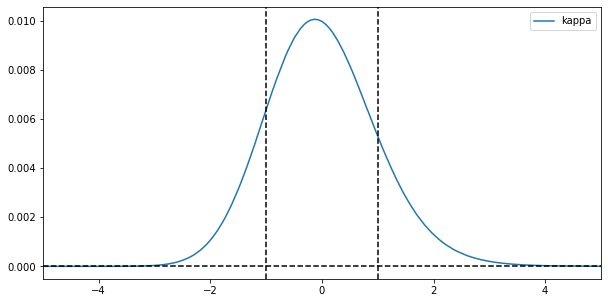

ksz


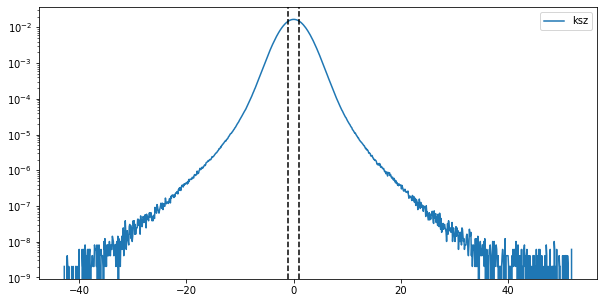

[-42.81297514536413, 2.347293290540834, -0.004066327476039634, 2.347293290540834]


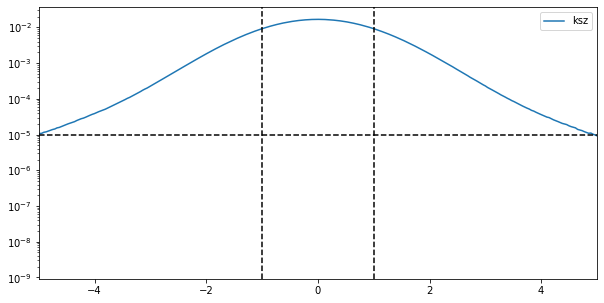

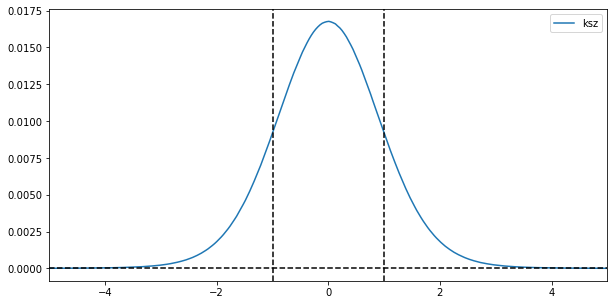

tsz


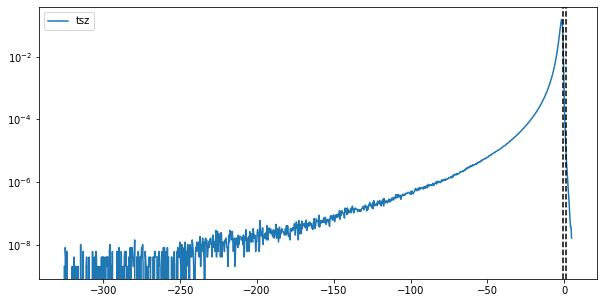

[-325.61087337535696, 2.7607056594886283, -1.3026021801816026, 0.16979196734319899]


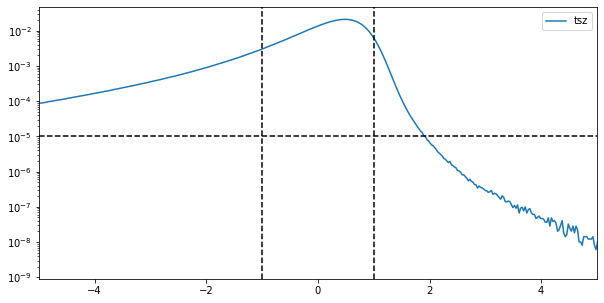

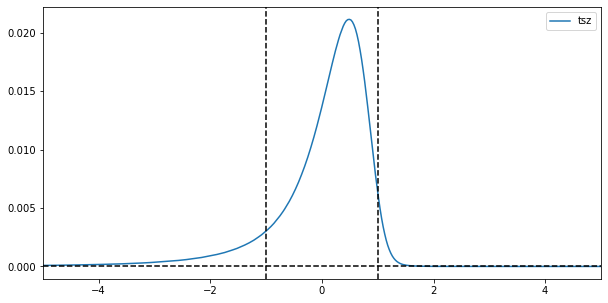

ir_pts


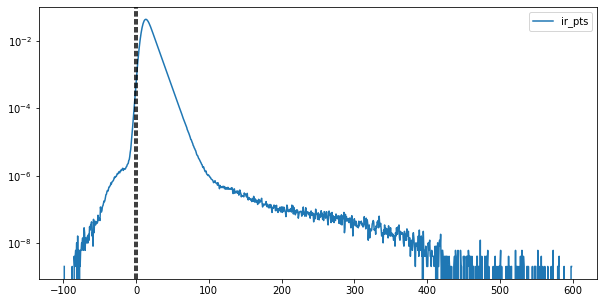

[-99.19439321687462, 8.239237217876058, 2.7099732225648534, 0.06363285593506174]


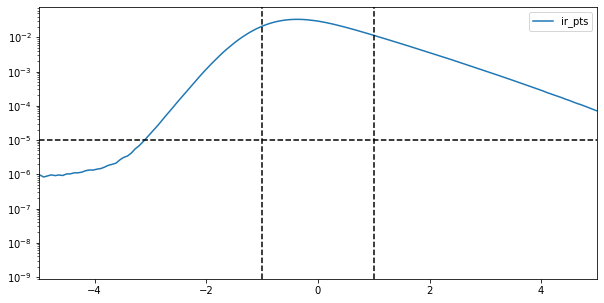

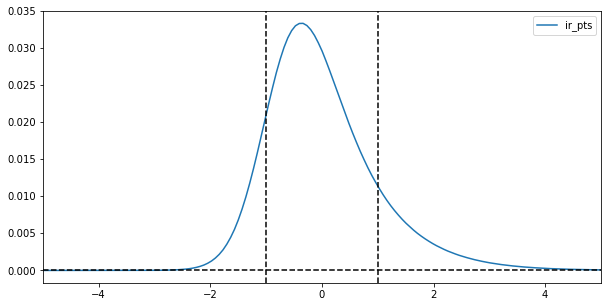

rad_pts


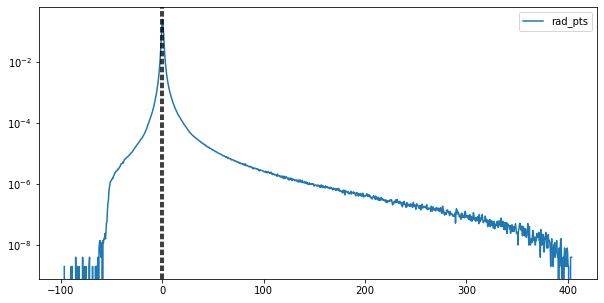

[-97.14696123044465, 4.090363447749766, 3.2113451399599824, 0.03107412292422967]


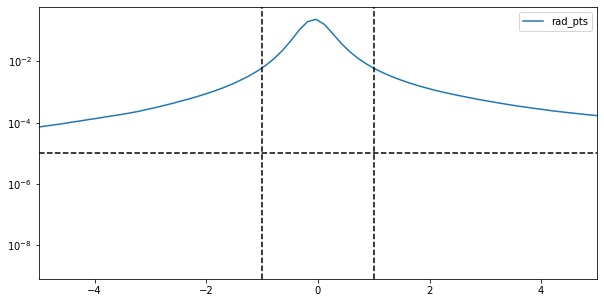

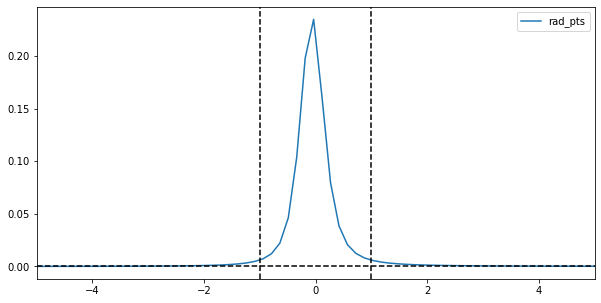

In [5]:
zfact = 1

def power_normalize(emap, pos_pow, neg_pow):
    temp = emap.copy()
    loc = np.where(emap>=0)
    temp[loc] = temp[loc]**pos_pow
    loc = np.where(emap<0)
    temp[loc] = -1*np.abs(temp[loc])**neg_pow
    return temp

def log_normalize(emap, pos=True, neg=True):
    temp = emap.copy()

    if pos:
        loc = np.where(emap>=0)
        std = np.std(temp[loc])
        temp[loc] = np.log(temp[loc]/std+1)
    if neg:
        loc = np.where(emap<0)
        std = np.std(temp[loc])
        temp[loc] = -1*np.log(np.abs(temp[loc]/std)+1)
    return temp


def log_normalizev2(emap, flipsign=False):
    #import pdb; pdb.set_trace()
    temp = emap.copy()
    if flipsign: temp *= -1.
    minval = np.min(temp)
    temp -= minval
    std = np.std(temp)
    temp = np.log(temp/std+1)
    if flipsign: temp *= -1.
    return temp


def arctanh_normalize(emap):
    return  np.arctanh(emap.copy())

def tanh_normalize(emap):
    return  np.tanh(emap.copy()), _

def mean_normalize(emap):
    temp = emap.copy()
    temp = temp - np.mean(temp)
    return temp, []

def minmax_normalize(emap, subtract_mean=True):
    mean = np.mean(emap)
    #emap = emap - mean
    max_val, min_val = emap.max(), emap.min()
    return (emap-mean)/(max_val-min_val)*2, [min_val, max_val, mean]

def z_normalize(emap, zfact = zfact):
    mean, std = emap.mean(), emap.std()
    
    return (emap-mean)/(std*zfact), [mean, std]

freq_idx = 148

'''
ns = {"kappa": minmax_normalize,
      "ksz": minmax_normalize,
      "ir_pts": lambda x: minmax_normalize(log_normalize(x)),
      "rad_pts": lambda x: minmax_normalize(log_normalize(x)),
      "tsz": lambda x: minmax_normalize(log_normalize(x)),
     }
'''


ns = {"kappa": z_normalize,
      "ksz": z_normalize,
      "ir_pts": lambda x: z_normalize(log_normalizev2(x, flipsign=False)),
      "rad_pts": lambda x: z_normalize(log_normalizev2(x, flipsign=False)),
      "tsz": lambda x: z_normalize(log_normalizev2(x, flipsign=True)),
     }

norm_info_model = {}
hist_org_model = {}
hist_norm_model = {}
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
for i, compt_idx in enumerate(compts):
    print(compt_idx)
    #if i <2: continue

    temp = data[i].copy()
    norm_info_model[compt_idx] = []
    norm_info_model[compt_idx] += [temp.min(), temp.std()]

    hist, bins = np.histogram(data[i].copy(), bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hist_org_model[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist/np.sum(hist), label=compt_idx)
    plt.legend()
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.yscale("log")
    plt.show()
    
    ndata, temp = ns[compt_idx](data[i].copy())
    norm_info_model[compt_idx] += temp
    print(norm_info_model[compt_idx])
    hist, bins = np.histogram(ndata, bins=1024)
    fig = plt.figure(figsize=(10, 5))
    hist_norm_model[compt_idx] = (hist, bins)
    bin_center = (bins[:-1]+bins[1:])/2.
    plt.plot(bin_center, hist/np.sum(hist), label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.axhline(y=1e-5, ls="--", color="k")
    plt.legend()
    plt.xlim(-5,5)
    
    plt.yscale("log")
    plt.show()
    
    hist, bins = np.histogram(ndata, bins=1024)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(bin_center, hist/np.sum(hist), label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.axhline(y=1e-5, ls="--", color="k")
    plt.legend()
    plt.xlim(-5,5)
    
    #plt.yscale("log")
    plt.show()


In [19]:
## 
## For minmax normalization
norm_info_model_out = {} 

for idx in norm_info_model.keys():
    norm_info_model_out[idx] = {"min":float(norm_info_model[idx][0]), "max":float(norm_info_model[idx][1]),
                          "mean":float(norm_info_model[idx][2])}

"""
## For minmax normalization
norm_info_model_out = {} 

for idx in norm_info_model.keys():
    norm_info_model_out[idx] = {"min":float(norm_info_model[idx][0]), "max":float(norm_info_model[idx][1]),
                          "mean":float(norm_info_model[idx][2])}
"""    
hist_org_model_out = {} 
for idx in hist_org_model.keys():
    hist_org_model_out[idx] = {}
    hist_org_model_out[idx]["hist"] = hist_org_model[idx][0]
    bin_edges =  hist_org_model[idx][1]
    hist_org_model_out[idx]["bin_centers"] = (bin_edges[:-1]+bin_edges[1:])/2.
    hist_org_model_out[idx]["bin_edges"] = bin_edges
    
hist_norm_model_out = {} 
for idx in hist_norm_model.keys():
    hist_norm_model_out[idx] = {}
    hist_norm_model_out[idx]["hist"] = hist_norm_model[idx][0]
    bin_edges =  hist_norm_model[idx][1]
    hist_norm_model_out[idx]["bin_centers"] = (bin_edges[:-1]+bin_edges[1:])/2.
    hist_norm_model_out[idx]["bin_edges"] = bin_edges


In [20]:
data_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def data_path(x):
    return os.path.join(data_dir, x)

def load_data(data_path):
    data = np.load(data_path, allow_pickle=True)    
    return {key:data[key].item() for key in data}

np.savez(data_path("092520_original_histogram_model.npz"), **hist_org_model_out)
np.savez(data_path("092520_normalized_histogram_model.npz"), **hist_norm_model_out)
np.savez(data_path("092520_normalization_info_model.npz"), **norm_info_model_out)


